Export street graph
====================
Use for exporting data from an existing rebuilt street graph

In [1]:
import warnings
warnings.filterwarnings('ignore')

import copy
import os
import sys
import networkx as nx
import numpy as np
import shutil

# Makes a local copy of current snman code
source_dir = os.path.join('C:',os.sep,'Users','lballo','polybox','GIT','github','snman','snman')
destination_dir = os.path.join('..','snman')
shutil.copytree(source_dir, destination_dir, dirs_exist_ok=True)

import snman
from snman.constants import *
from snman import osmnx_customized as oxc

# Set these paths according to your own setup
data_directory = os.path.join('C:',os.sep,'Users','lballo','polybox','Research','Accessibility','QGIS','statpop_descriptive')
snman_inputs = os.path.join('C:',os.sep,'Users','lballo','polybox','Research','SNMan','SNMan Shared','data_v2','inputs')

CRS_internal = 2056      # for Zurich
CRS_for_export = 2056

In [65]:
# LOAD STATPOP
import geopandas as gpd

statpop = gpd.read_file(
    os.path.join(snman_inputs,'switzerland','switzerland','statpop','statpop2017.gpkg'),
    include_fields=['residencepermit', 'age', 'sex']
)

In [80]:
import math
import geopandas as gpd
from shapely.geometry import Polygon

# based on code from here:
# https://gis.stackexchange.com/questions/341218/creating-a-hexagonal-grid-of-regular-hexagons-of-definite-area-anywhere-on-the-g

def create_hexagon(l, x, y):
    """
    Create a hexagon centered on (x, y)
    :param l: length of the hexagon's edge
    :param x: x-coordinate of the hexagon's center
    :param y: y-coordinate of the hexagon's center
    :return: The polygon containing the hexagon's coordinates
    """
    c = [[x + math.cos(math.radians(angle)) * l, y + math.sin(math.radians(angle)) * l] for angle in range(0, 360, 60)]
    return Polygon(c)

def create_hexgrid(bbox, side, crs=2056):
    """
    returns an array of Points describing hexagons centers that are inside the given bounding_box
    :param bbox: The containing bounding box. The bbox coordinate should be in Webmercator.
    :param side: The size of the hexagons'
    :return: The hexagon grid
    """
    grid = []

    v_step = math.sqrt(3) * side
    h_step = 1.5 * side

    x_min = min(bbox[0], bbox[2])
    x_max = max(bbox[0], bbox[2])
    y_min = min(bbox[1], bbox[3])
    y_max = max(bbox[1], bbox[3])

    h_skip = math.ceil(x_min / h_step) - 1
    h_start = h_skip * h_step

    v_skip = math.ceil(y_min / v_step) - 1
    v_start = v_skip * v_step

    h_end = x_max + h_step
    v_end = y_max + v_step

    if v_start - (v_step / 2.0) < y_min:
        v_start_array = [v_start + (v_step / 2.0), v_start]
    else:
        v_start_array = [v_start - (v_step / 2.0), v_start]

    v_start_idx = int(abs(h_skip) % 2)

    c_x = h_start
    c_y = v_start_array[v_start_idx]
    v_start_idx = (v_start_idx + 1) % 2
    while c_x < h_end:
        while c_y < v_end:
            grid.append((c_x, c_y))
            c_y += v_step
        c_x += h_step
        c_y = v_start_array[v_start_idx]
        v_start_idx = (v_start_idx + 1) % 2

    grid = list(map(lambda coords: create_hexagon(side, *coords), grid))
    grid = gpd.GeoDataFrame(geometry=grid, crs=crs)
    return grid


grid = create_hexgrid((2670851, 1236374, 2694153, 1261337), 200)
grid.to_file(os.path.join(data_directory,'statpop_hex.gpkg'))

<Axes: >

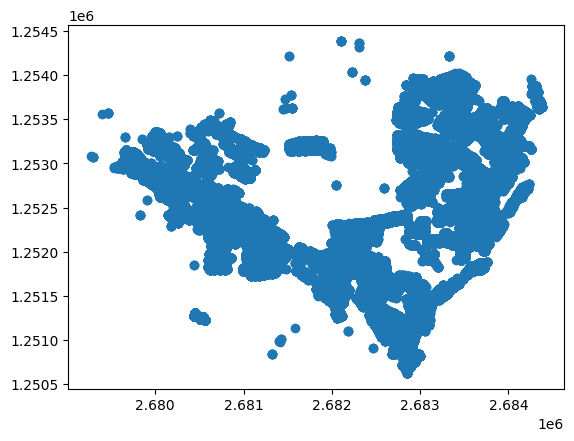

In [43]:
statpop.plot()

In [70]:
statpop['swiss'] = statpop['residencepermit'] == -2
statpop['non_swiss'] = statpop['residencepermit'] != -2
statpop['elderly'] = statpop['age'] >= 65
statpop['young'] = statpop['age'] < 25
statpop['male'] = statpop['sex'] == 1
statpop['female'] = statpop['sex'] == 2


statpop_reduced = statpop[['geometry', 'swiss', 'non_swiss', 'elderly', 'young', 'male', 'female']]
statpop_reduced

,geometry,swiss,non_swiss,elderly,young,male,female
0,POINT (2674380.001 1250094.001),False,True,False,False,True,False
1,POINT (2672299.001 1251208.001),False,True,False,False,False,True
2,POINT (2673496.001 1250355.001),False,True,False,False,True,False
3,POINT (2671984.001 1250827.001),False,True,False,False,True,False
4,POINT (2671984.001 1250827.001),False,True,False,True,False,True
...,...,...,...,...,...,...,...
2227242,POINT (2659576.001 1251240.001),False,True,False,True,False,True
2227243,POINT (2682933.001 1253605.001),False,True,False,True,True,False
2227244,POINT (2683348.001 1250702.001),False,True,False,True,False,True
2227245,POINT (2688172.001 1233863.001),True,False,False,True,True,False


In [81]:
joined = gpd.sjoin(grid, statpop_reduced, how='left', op='intersects')
joined['aggregation_bin'] = joined.index

joined = joined.groupby('aggregation_bin').agg(
    {
        'swiss': 'sum',
        'non_swiss': 'sum',
        'elderly': 'sum',
        'young': 'sum',
        'male': 'sum',
        'female': 'sum',
        'geometry': 'first'
    }
)

joined = joined.astype({
        'swiss': 'int',
        'non_swiss': 'int',
        'elderly': 'int',
        'young': 'int',
        'male': 'int',
        'female': 'int',
})

joined = gpd.GeoDataFrame(joined, crs=2056, geometry='geometry')



joined.to_file(os.path.join(data_directory,'statpop_hex.gpkg'))

In [77]:
joined

,swiss,non_swiss,elderly,young,male,female,geometry
aggregation_bin,,,,,,,
0,0,0,0,0,0,0,"POLYGON ((2670875.000 1236337.866, 2670850.000..."
1,0,0,0,0,0,0,"POLYGON ((2670875.000 1236424.469, 2670850.000..."
2,0,0,0,0,0,0,"POLYGON ((2670875.000 1236511.072, 2670850.000..."
3,0,0,0,0,0,0,"POLYGON ((2670875.000 1236597.674, 2670850.000..."
4,0,0,0,0,0,0,"POLYGON ((2670875.000 1236684.277, 2670850.000..."
...,...,...,...,...,...,...,...
90765,0,0,0,0,0,0,"POLYGON ((2694275.000 1261019.590, 2694250.000..."
90766,0,0,0,0,0,0,"POLYGON ((2694275.000 1261106.193, 2694250.000..."
90767,0,0,0,0,0,0,"POLYGON ((2694275.000 1261192.796, 2694250.000..."
